In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [13]:
# LOAD DATA
df = pd.read_csv("spam.csv", encoding="latin-1")[["v1", "v2"]]
df.columns = ["label", "text"]
df["label"] = (df["label"] == "spam").astype(int)  # spam=1, ham=0

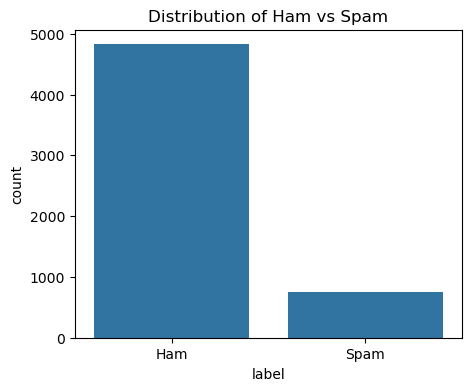

In [14]:
# EDA 
# Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x="label", data=df)
plt.xticks([0, 1], ["Ham", "Spam"])
plt.title("Distribution of Ham vs Spam")
plt.show()

The above bar chart shows the distribution of messages in our dataset. The blue bars represent the count of messages labeled as 'Ham' (non-spam) and 'Spam'. As we can see, there are around 4,800 ham messages compared to roughly 700 spam messages. This indicates that the dataset is imbalanced, with ham messages making up the majority. This imbalance is important to consider because it can affect model training, so techniques like stratified sampling or class balancing might be needed to ensure fair evaluation.

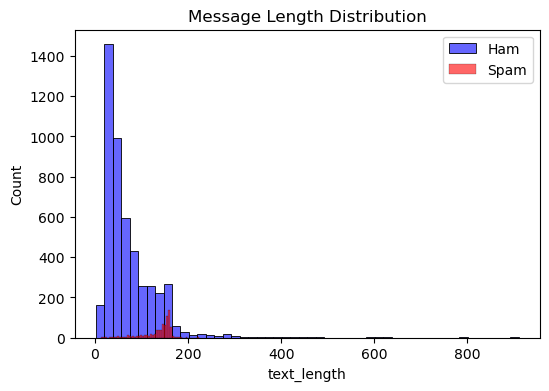

In [15]:
# Message length distribution
df["text_length"] = df["text"].apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df[df["label"]==0]["text_length"], bins=50, color="blue", label="Ham", alpha=0.6)
sns.histplot(df[df["label"]==1]["text_length"], bins=50, color="red", label="Spam", alpha=0.6)
plt.legend()
plt.title("Message Length Distribution")
plt.show()

This histogram compares the distribution of message lengths for ham and spam messages. Most ham messages are relatively short, clustering below 150 characters. Spam messages tend to be slightly longer on average and more spread out, with some reaching higher lengths. This difference in message length patterns could help the model distinguish between ham and spam messages.

In [16]:
# Top frequent words by label
def get_top_words(texts, n=20):
    words = " ".join(texts).lower()
    words = re.findall(r'\b\w+\b', words)
    return Counter(words).most_common(n)

print("Top words in spam:", get_top_words(df[df["label"]==1]["text"]))
print("\nTop words in ham:", get_top_words(df[df["label"]==0]["text"]))

Top words in spam: [('to', 688), ('a', 377), ('call', 355), ('å', 299), ('you', 297), ('your', 264), ('free', 224), ('2', 206), ('the', 206), ('for', 203), ('now', 199), ('or', 188), ('u', 174), ('txt', 163), ('is', 158), ('on', 144), ('ur', 144), ('4', 137), ('have', 135), ('from', 131)]

Top words in ham: [('i', 2940), ('you', 1943), ('to', 1554), ('the', 1122), ('a', 1056), ('u', 1018), ('and', 857), ('in', 818), ('me', 772), ('my', 750), ('is', 732), ('it', 711), ('that', 551), ('of', 525), ('for', 501), ('s', 478), ('have', 440), ('can', 439), ('so', 435), ('but', 434)]


For spam, common words include 'to', 'call', 'free', and numbers like '2' or '4', which are typical in promotional or scam messages.
For ham, frequent words are conversational ones like 'I', 'you', 'to', 'the', and 'my', which reflect normal personal communication.
This difference in vocabulary patterns shows that spam tends to use persuasive or offer-related terms, while ham uses more casual, everyday language.

In [17]:
# TRAIN/TEST SPLIT with stratify
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42)

In [18]:
# TF-IDF
tfidf = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2), max_df=0.9, min_df=2)

In [19]:
# MODELS & HYPERPARAMETER TUNING 
# Logistic Regression
log_pipe = Pipeline([("vec", tfidf), ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))])
log_params = {
    "vec__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.5, 1, 2],
    "clf__solver": ["lbfgs"]
}
log_grid = GridSearchCV(log_pipe, log_params, cv=5, n_jobs=-1, scoring="f1")
log_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec',
                                        TfidfVectorizer(max_df=0.9, min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        LogisticRegression(max_iter=2000,
                                                           n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.5, 1, 2], 'clf__solver': ['lbfgs'],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1')

The dataset is split into training and testing sets using an 80-20 ratio, while applying stratify to make sure the class distribution of ham and spam remains the same in both sets.
Next,TF-IDF vectorization is used to convert the text messages into numerical features and applied preprocessing like lowercasing, removing English stopwords, and including both unigrams and bigrams.
For the model, a Logistic Regression pipeline and tuned hyperparameters using GridSearchCV with 5-fold cross-validation is built and then optimized the model based on the F1-score, which is important for imbalanced datasets because it balances precision and recall.

In [20]:
# SVM
svm_pipe = Pipeline([("vec", tfidf), ("clf", LinearSVC())])
svm_params = {
    "vec__ngram_range": [(1,1), (1,2)],
    "clf__C": [0.5, 1, 2]
}
svm_grid = GridSearchCV(svm_pipe, svm_params, cv=5, n_jobs=-1, scoring="f1")
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec',
                                        TfidfVectorizer(max_df=0.9, min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.5, 1, 2],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1')

For SVM, I used LinearSVC inside a pipeline with TF-IDF vectorization, tuning parameters like the n-gram range and the regularization parameter C.

In [21]:
# Naive Bayes
nb_pipe = Pipeline([("vec", tfidf), ("clf", MultinomialNB())])
nb_params = {
    "vec__ngram_range": [(1,1), (1,2)],
    "clf__alpha": [0.1, 0.5, 1.0]
}
nb_grid = GridSearchCV(nb_pipe, nb_params, cv=5, n_jobs=-1, scoring="f1")
nb_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vec',
                                        TfidfVectorizer(max_df=0.9, min_df=2,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.1, 0.5, 1.0],
                         'vec__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1')

For Naive Bayes, we used MultinomialNB with TF-IDF and tuned parameters like n-gram range and smoothing parameter alpha.
Both models were optimized using GridSearchCV with 5-fold cross-validation and the F1-score as the evaluation metric, to ensure balanced performance between precision and recall on this imbalanced dataset.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


best_models = {
    "Logistic Regression": log_grid.best_estimator_,
    "SVM": svm_grid.best_estimator_,
    "Naive Bayes": nb_grid.best_estimator_
}

def print_metrics(name, y_true, y_pred, y_score=None):
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    if y_score is not None:
        try:
            print("ROC-AUC  :", roc_auc_score(y_true, y_score))
        except Exception:
            pass

for name, pipe in best_models.items():
    y_pred = pipe.predict(X_test)
    y_score = (pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, "predict_proba") 
               else pipe.decision_function(X_test) if hasattr(pipe, "decision_function") 
               else None)
    print_metrics(name, y_test, y_pred, y_score)


Logistic Regression
Accuracy : 0.9775784753363229
Precision: 0.984375
Recall   : 0.8456375838926175
F1 Score : 0.9097472924187726
ROC-AUC  : 0.9867091861547653

SVM
Accuracy : 0.9838565022421525
Precision: 0.9851851851851852
Recall   : 0.8926174496644296
F1 Score : 0.9366197183098591
ROC-AUC  : 0.9876054302666499

Naive Bayes
Accuracy : 0.9829596412556054
Precision: 0.9850746268656716
Recall   : 0.8859060402684564
F1 Score : 0.9328621908127208
ROC-AUC  : 0.9928856281351175


Logistic Regression achieved about 97.76% accuracy, with very high precision (98.43%), meaning it’s excellent at avoiding false positives. Its recall is slightly lower (84.65%), meaning it misses some spam messages.

SVM had slightly higher accuracy (98.39%) and recall than Logistic Regression, leading to a balanced F1 score of 93.66%.

Naive Bayes also performed very well (98.29% accuracy) with the highest ROC-AUC score (99.28%), showing it’s excellent at separating spam from ham.

Overall, all three models performed strongly, but SVM and Naive Bayes slightly outperformed Logistic Regression in recall and ROC-AUC, making them slightly better at catching spam while still keeping false positives low.

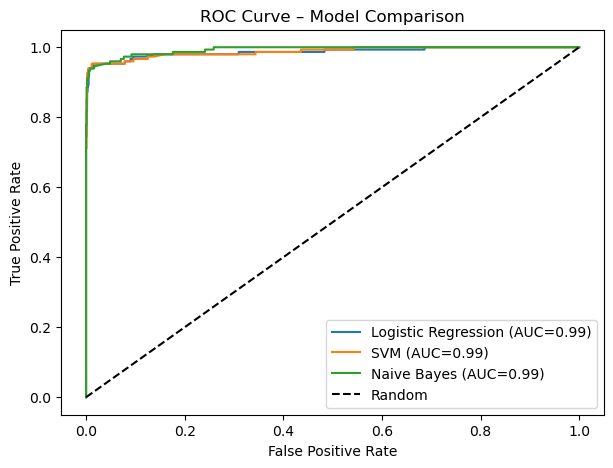

In [24]:
# Logistic Regression
y_log = log_grid.predict_proba(X_test)[:, 1]

# SVM 
if hasattr(svm_grid, "predict_proba"):
    y_svm = svm_grid.predict_proba(X_test)[:, 1]
else:
    y_svm = svm_grid.decision_function(X_test)

# Naive Bayes
y_nb = nb_grid.predict_proba(X_test)[:, 1]

# Compute ROC points
fpr_log, tpr_log, _ = roc_curve(y_test, y_log)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_svm)
fpr_nb,  tpr_nb,  _ = roc_curve(y_test, y_nb)

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={roc_auc_score(y_test, y_log):.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={roc_auc_score(y_test, y_svm):.2f})")
plt.plot(fpr_nb,  tpr_nb,  label=f"Naive Bayes (AUC={roc_auc_score(y_test, y_nb):.2f})")
plt.plot([0,1], [0,1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Model Comparison")
plt.legend(loc="lower right")
plt.show()


This chart shows how well the three models Logistic Regression, SVM, and Naive Bayes can separate spam from ham. The closer a curve is to the top-left corner, the better the model. The dashed line is just random guessing. All three models have AUC scores around 0.99, which means they are all excellent. Naive Bayes’ curve looks a bit longer because it produces a wider range of probability values, but its performance is still just as strong as the others.

In [25]:
import pickle

best_model = nb_grid.best_estimator_

with open("model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Saving the TF-IDF vectorizer for the api
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(best_model.named_steps["vec"], f)

print("Model and vectorizer saved successfully with pickle.")


Model and vectorizer saved successfully with pickle.


After testing all three models, I chose the best-performing one — in this case, Naive Bayes — and saved it using pickle. I also saved the TF-IDF vectorizer from the pipeline, because it’s needed to transform new messages in the same way as the training data. This means I can load both the model and vectorizer later for predictions without retraining the model.